## Importing all the modules and libraries

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud
import re

## Loading the Dataset 

In [24]:

# import library and read dataset

import os
import json

if not os.path.exists("kaggle.json"):
    print("Please download your Kaggle API token from https://www.kaggle.com/account and save it as kaggle.json in the current directory.")
    sys.exit(1)
with open("kaggle.json", "r") as file:
    kaggle_token = json.load(file)

os.environ['KAGGLE_USERNAME'] = kaggle_token['username']
os.environ['KAGGLE_KEY'] = kaggle_token['key']

In [25]:
import zipfile

with zipfile.ZipFile("fake-and-real-news-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("news_data")

In [26]:
import pandas as pd

fake_df = pd.read_csv("news_data/Fake.csv")
real_df = pd.read_csv("news_data/True.csv")

print("Fake News Shape:", fake_df.shape)
print("Real News Shape:", real_df.shape)

Fake News Shape: (23481, 4)
Real News Shape: (21417, 4)


## EDA and visualization

Dataset loaded successfully!
Dataset shape: (44898, 5)
Columns: ['title', 'text', 'subject', 'date', 'label']

First few rows:


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB

Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64
Fake news: 23481
Real news: 21417


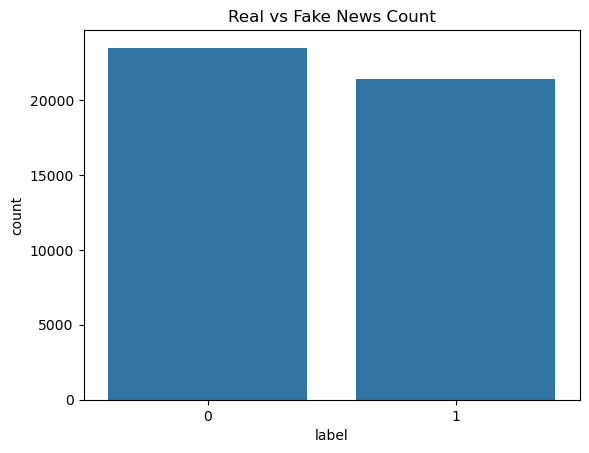

In [27]:
fake_df["label"] = 0
real_df["label"] = 1

df = pd.concat([fake_df, real_df], axis=0).reset_index(drop=True)

if df is not None:
    print("Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print("\nFirst few rows:")
    display(df.head())
    
    print("\nDataset info:")
    df.info()
    
    print("\nLabel distribution:")
    print(df['label'].value_counts())
    print(f"Fake news: {(df['label'] == 0).sum()}")
    print(f"Real news: {(df['label'] == 1).sum()}")
    sns.countplot(data=df, x='label')
    plt.title("Real vs Fake News Count")
    plt.show()

<Axes: xlabel='subject'>

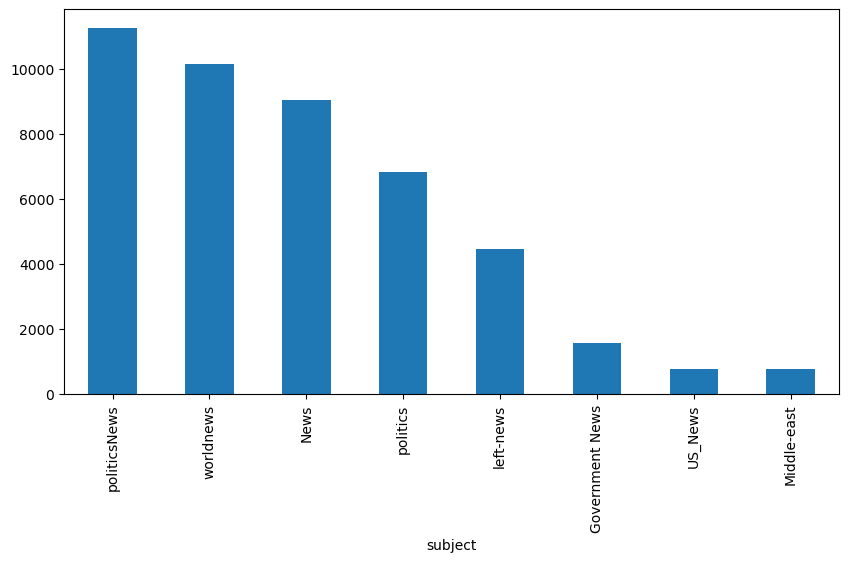

In [28]:
def create_domain_mapping(df):
    #Creating domain categories based on subject
    domain_mapping = {
        'politicsNews': 'Politics',
        'Government News': 'Politics',
        'politics': 'Politics',
        'worldnews': 'News',
        'News': 'News',
        'left-news': 'Politics',
        'US_News': 'News',
        'Middle-east': 'News',
    }
    
    df['domain'] = df['subject'].map(domain_mapping)
    df['domain'] = df['domain'].fillna('Other')
    
    return df

df = create_domain_mapping(df)

df["subject"].value_counts().plot(kind='bar', figsize=(10, 5))

In [29]:
df['combined_text'] = df['title'] + ' ' + df['text']

In [30]:

df = df[['combined_text', 'domain','label']]

In [31]:
df

,combined_text,domain,label
0,Donald Trump Sends Out Embarrassing New Year’...,News,0
1,Drunk Bragging Trump Staffer Started Russian ...,News,0
2,Sheriff David Clarke Becomes An Internet Joke...,News,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,News,0
4,Pope Francis Just Called Out Donald Trump Dur...,News,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,News,1
44894,LexisNexis withdrew two products from Chinese ...,News,1
44895,Minsk cultural hub becomes haven from authorit...,News,1
44896,Vatican upbeat on possibility of Pope Francis ...,News,1


=== EXPLORATORY DATA ANALYSIS ===

Domain distribution:
domain
Politics    24142
News        20756
Name: count, dtype: int64

Label distribution by domain:


label,0,1
domain,,
News,51.12,48.88
Politics,53.31,46.69


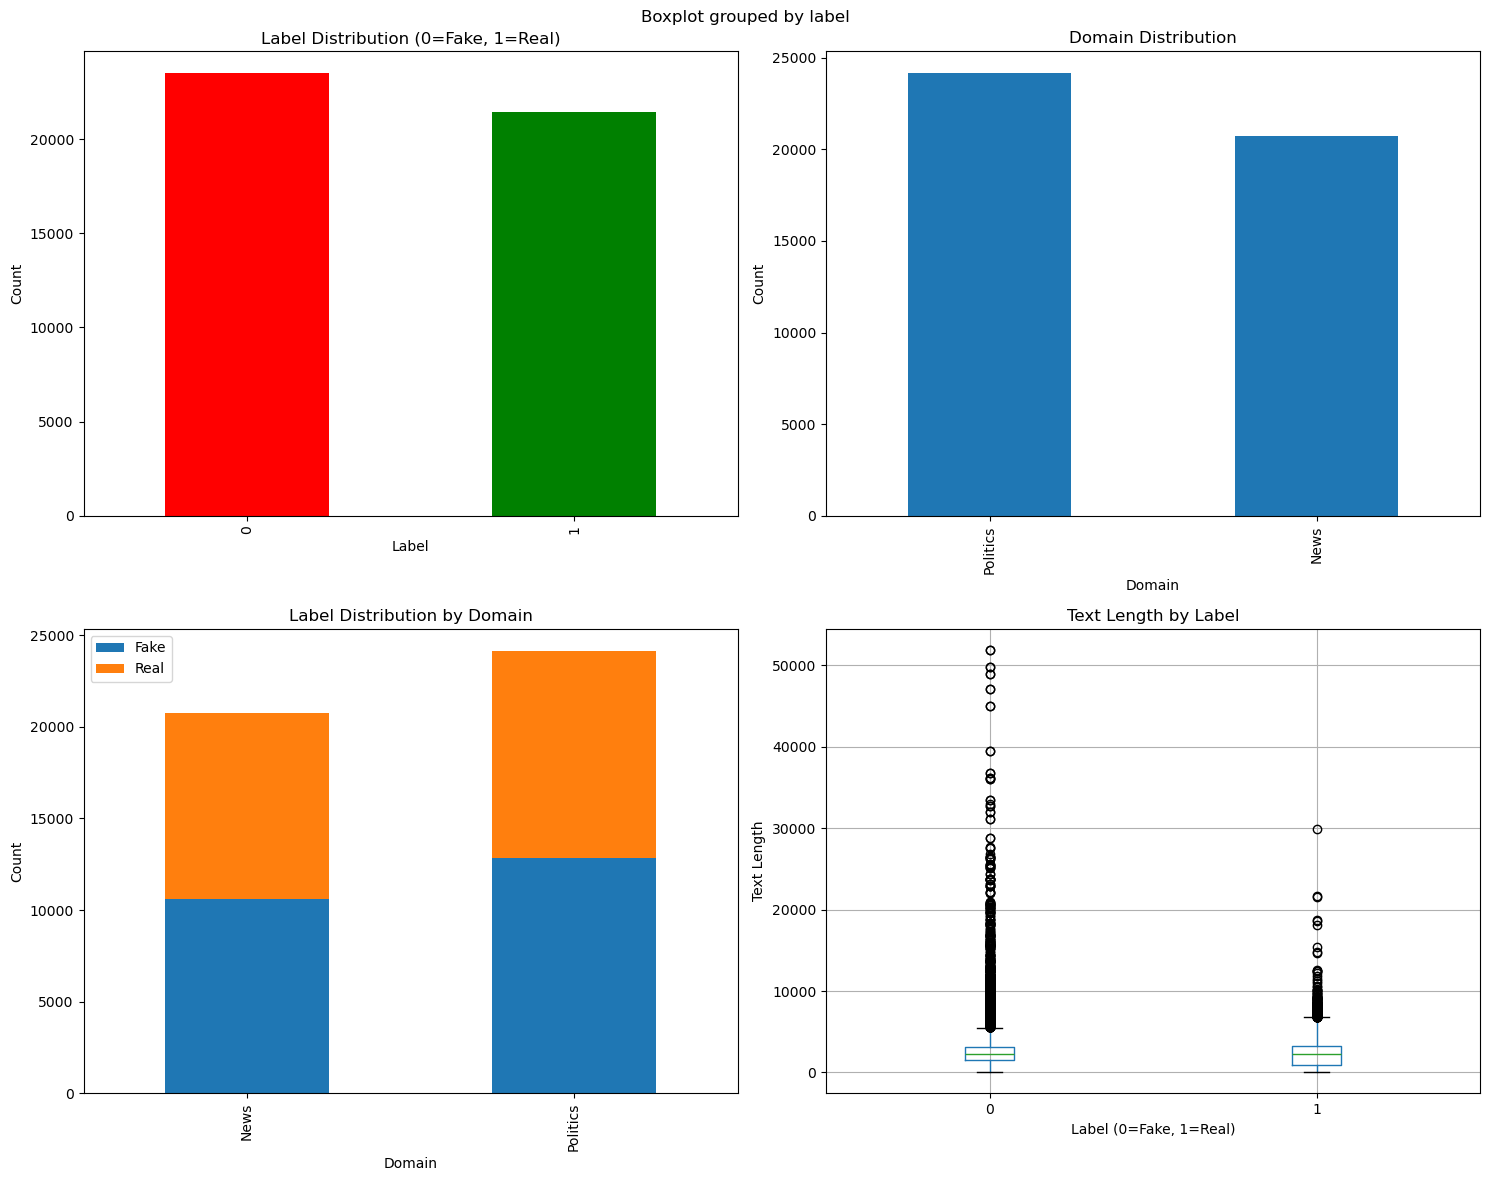


Average text length by label:
label
0    2642.594268
1    2448.946398
Name: text_length, dtype: float64

Average text length by domain:
domain
News        2655.726874
Politics    2459.513462
Name: text_length, dtype: float64


In [32]:
print("=== EXPLORATORY DATA ANALYSIS ===")
print("\nDomain distribution:")
print(df['domain'].value_counts())
    
print("\nLabel distribution by domain:")
domain_label_dist = pd.crosstab(df['domain'], df['label'], normalize='index') * 100
display(domain_label_dist.round(2))
    
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Label distribution
df['label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['red', 'green'])
axes[0,0].set_title('Label Distribution (0=Fake, 1=Real)')
axes[0,0].set_xlabel('Label')
axes[0,0].set_ylabel('Count')
    
    # Domain distribution
df['domain'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Domain Distribution')
axes[0,1].set_xlabel('Domain')
axes[0,1].set_ylabel('Count')
    
    # Label by domain
pd.crosstab(df['domain'], df['label']).plot(kind='bar', ax=axes[1,0], stacked=True)
axes[1,0].set_title('Label Distribution by Domain')
axes[1,0].set_xlabel('Domain')
axes[1,0].set_ylabel('Count')
axes[1,0].legend(['Fake', 'Real'])
    
    # Text length analysis
df['text_length'] = df['combined_text'].str.len()
df.boxplot(column='text_length', by='label', ax=axes[1,1])
axes[1,1].set_title('Text Length by Label')
axes[1,1].set_xlabel('Label (0=Fake, 1=Real)')
axes[1,1].set_ylabel('Text Length')
    
plt.tight_layout()
plt.show()
    
    # Text analysis
print(f"\nAverage text length by label:")
print(df.groupby('label')['text_length'].mean())
    
print(f"\nAverage text length by domain:")
print(df.groupby('domain')['text_length'].mean())


## Preprocessing

In [33]:
import re
import string
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions and hashtags
    text = re.sub(r'\@\w+|\#','', text)
    
    # Remove punctuation and digits
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vishal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
df['clean_text'] = df['combined_text'].apply(clean_text)

In [35]:
df['clean_text']

0        donald trump sends embarrassing new years eve ...
1        drunk bragging trump staffer started russian c...
2        sheriff david clarke becomes internet joke thr...
3        trump obsessed even obamas name coded website ...
4        pope francis called donald trump christmas spe...
                               ...                        
44893    fully committed nato backs new us approach afg...
44894    lexisnexis withdrew two products chinese marke...
44895    minsk cultural hub becomes authorities minsk r...
44896    vatican upbeat possibility pope francis visiti...
44897    indonesia buy billion worth russian jets jakar...
Name: clean_text, Length: 44898, dtype: object

## VECTORISATION + FEATURE AUGMENTATION

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1,2))
X_text = tfidf.fit_transform(df['clean_text'])

In [37]:
X_text.shape

(44898, 3000)

In [38]:
import numpy as np
from scipy.sparse import hstack

text_length = df['text_length'].values.reshape(-1, 1)
X_combined = hstack([X_text, text_length])

In [39]:
X_combined.shape

(44898, 3001)

## Train and Test Split 

In [40]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(X_combined, df['label'], test_size=0.33, random_state=42, stratify=df['label'])

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

## Model Deployment

## Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix

# === LOGISTIC REGRESSION ===
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
params_lr = {'C': [0.1, 1, 10]}

grid_lr = GridSearchCV(log_reg, param_grid=params_lr, scoring='f1', cv=5, n_jobs=-1)
grid_lr.fit(X_train_resampled, y_train_resampled)
print("Best Logistic Regression Params:", grid_lr.best_params_)

/Users/vishal/anaconda3/envs/news_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vishal/anaconda3/envs/news_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Best Logistic Regression Params: {'C': 10}


## Linear SVM


In [42]:
from sklearn.svm import LinearSVC

params_svc = {'C': [0.1, 1, 10]}
svc = LinearSVC(class_weight='balanced', max_iter=5000)

grid_svc = GridSearchCV(svc, param_grid=params_svc, scoring='f1', cv=3, n_jobs=-1)
grid_svc.fit(X_train_resampled, y_train_resampled)
print("Best SVM Params:", grid_svc.best_params_)

Best SVM Params: {'C': 10}


## XGBoost

In [53]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    scale_pos_weight=(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum(),
    use_label_encoder=False,
    early_stopping_rounds=10,
    eval_metric='logloss'
)

xgb.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-logloss:0.60005


/Users/vishal/anaconda3/envs/news_env/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [01:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[1]	validation_0-logloss:0.52382
[2]	validation_0-logloss:0.46030
[3]	validation_0-logloss:0.40665
[4]	validation_0-logloss:0.36087
[5]	validation_0-logloss:0.32146
[6]	validation_0-logloss:0.28732
[7]	validation_0-logloss:0.25758
[8]	validation_0-logloss:0.23156
[9]	validation_0-logloss:0.20870
[10]	validation_0-logloss:0.18842
[11]	validation_0-logloss:0.17058
[12]	validation_0-logloss:0.15460
[13]	validation_0-logloss:0.14058
[14]	validation_0-logloss:0.12796
[15]	validation_0-logloss:0.11675
[16]	validation_0-logloss:0.10685
[17]	validation_0-logloss:0.09787
[18]	validation_0-logloss:0.09004
[19]	validation_0-logloss:0.08289
[20]	validation_0-logloss:0.07638
[21]	validation_0-logloss:0.07061
[22]	validation_0-logloss:0.06549
[23]	validation_0-logloss:0.06081
[24]	validation_0-logloss:0.05669
[25]	validation_0-logloss:0.05298
[26]	validation_0-logloss:0.04953
[27]	validation_0-logloss:0.04652
[28]	validation_0-logloss:0.04379
[29]	validation_0-logloss:0.04133
[30]	validation_0-loglo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [56]:
evaluate_model(xgb, X_test, y_test, "XGBoost (Early Stop)")


🔹 XGBoost (Early Stop) Evaluation 🔹
Confusion Matrix:
 [[7722   27]
 [  15 7053]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7749
           1       1.00      1.00      1.00      7068

    accuracy                           1.00     14817
   macro avg       1.00      1.00      1.00     14817
weighted avg       1.00      1.00      1.00     14817

F1 Score: 0.997
ROC AUC: 1.000


In [57]:
grid = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum()
    ),
    param_grid={
        'n_estimators': [100],
        'max_depth': [3, 5],
        'learning_rate': [0.1]
    },
    scoring='f1',
    cv=3,
    n_jobs=-1
)

grid.fit(X_train_resampled, y_train_resampled)

print("Best Params:", grid.best_params_)
evaluate_model(grid.best_estimator_, X_test, y_test, "XGBoost (GridSearch)")

/Users/vishal/anaconda3/envs/news_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:50:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/vishal/anaconda3/envs/news_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:50:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/vishal/anaconda3/envs/news_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:50:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/vishal/anaconda3/envs/news_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:50:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.

Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

🔹 XGBoost (GridSearch) Evaluation 🔹
Confusion Matrix:
 [[7731   18]
 [  14 7054]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7749
           1       1.00      1.00      1.00      7068

    accuracy                           1.00     14817
   macro avg       1.00      1.00      1.00     14817
weighted avg       1.00      1.00      1.00     14817

F1 Score: 0.998
ROC AUC: 1.000


## Naive Bayes

In [59]:
# === NAIVE BAYES ===
# Only works with TF-IDF directly, no additional feature
nb = MultinomialNB()
nb.fit(X_train_resampled[:, :-1], y_train_resampled)  # exclude length if last column

MultinomialNB()

In [ ]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    
    try:
        y_probs = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        try:
            y_probs = model.decision_function(X_test)
        except:
            y_probs = y_pred  # fallback

    print(f"\n🔹 {model_name} Evaluation 🔹")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_probs):.3f}")

In [61]:
# Logistic Regression
evaluate_model(grid_lr.best_estimator_, X_test, y_test, "Logistic Regression")

# Linear SVM
evaluate_model(grid_svc.best_estimator_, X_test, y_test, "Linear SVM")

# XGBoost (choose either from grid or early-stopped version)
# If you used manual early stopping:
evaluate_model(xgb, X_test, y_test, "XGBoost (Early Stopping)")

# If you used GridSearch without early stopping:
# evaluate_model(grid_xgb.best_estimator_, X_test, y_test, "XGBoost (GridSearch)")

# Multinomial Naive Bayes (NOTE: only use TF-IDF part, exclude text length feature)
evaluate_model(nb, X_test[:, :-1], y_test, "Multinomial Naive Bayes")


🔹 Logistic Regression Evaluation 🔹
Confusion Matrix:
 [[7698   51]
 [  39 7029]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7749
           1       0.99      0.99      0.99      7068

    accuracy                           0.99     14817
   macro avg       0.99      0.99      0.99     14817
weighted avg       0.99      0.99      0.99     14817

F1 Score: 0.994
ROC AUC: 1.000

🔹 Linear SVM Evaluation 🔹
Confusion Matrix:
 [[7648  101]
 [  52 7016]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7749
           1       0.99      0.99      0.99      7068

    accuracy                           0.99     14817
   macro avg       0.99      0.99      0.99     14817
weighted avg       0.99      0.99      0.99     14817

F1 Score: 0.989
ROC AUC: 0.999

🔹 XGBoost (Early Stopping) Evaluation 🔹
Confusion Matrix:
 [[7722   27]
 [  15 7

### Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
params_lr = {'C': [0.1, 1, 10]}

grid_lr = GridSearchCV(log_reg, params_lr, scoring='f1', cv=5)
grid_lr.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             param_grid={'C': [0.1, 1, 10]}, scoring='f1')

### SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC(class_weight='balanced')
params_svc = {'C': [0.1, 1, 10], 'kernel': ['linear']}

grid_svc = GridSearchCV(svc, params_svc, scoring='f1', cv=3)
grid_svc.fit(X_train_resampled, y_train_resampled)

### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=class_weights[0]/class_weights[1])
params_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7]}

grid_xgb = GridSearchCV(xgb, params_xgb, scoring='f1', cv=3)
grid_xgb.fit(X_train_resampled, y_train_resampled)